### 2.1 Importing essential libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import random
import re
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

### 2.2 Import the Cleaned Instagram Dataset 

In [2]:
data = pd.read_csv("Datasets/cleaned-IG-data.csv", encoding = "utf-8",sep=",")

In [3]:
data = data.drop('Unnamed: 0', axis = 1)
temp = data
data

,Impressions,Comments,Shares,Likes,Caption,Hashtags
0,3920,9,5,162,import data visual everi financi data analysts...,financ money busi invest invest trade stockmar...
1,5394,7,14,224,best data scienc project idea healthcar want b...,healthcar health covid data datasci dataanalys...
2,4021,11,1,131,learn train machin learn model give input trai...,data datasci dataanalysi dataanalyt datascient...
3,4528,10,7,213,here write python program detect whether sente...,python pythonprogram pythonproject pythoncod p...
4,2518,5,4,123,plot annot visual data consid good practic mak...,datavisu datasci data dataanalyt machinelearn ...
...,...,...,...,...,...,...
114,13700,2,38,373,best data scienc certif choos datasci datascie...,datasci datasciencejob datasciencetrain datasc...
115,5731,4,1,148,cluster machin learn techniqu use classifi dat...,machinelearn machinelearningalgorithm datasci ...
116,4139,0,1,92,cluster music genr task group music base simil...,machinelearn machinelearningalgorithm datasci ...
117,32695,2,75,549,best data scienc certif choos datasci datascie...,datasci datasciencejob datasciencetrain datasc...


### 2.3 Bootstrapping the current dataset

#### 2.3.1 Bootstrapping Numerical Data

In [4]:
numerical_data = data.drop(['Hashtags', 'Caption'], axis=1)
numerical_data

,Impressions,Comments,Shares,Likes
0,3920,9,5,162
1,5394,7,14,224
2,4021,11,1,131
3,4528,10,7,213
4,2518,5,4,123
...,...,...,...,...
114,13700,2,38,373
115,5731,4,1,148
116,4139,0,1,92
117,32695,2,75,549


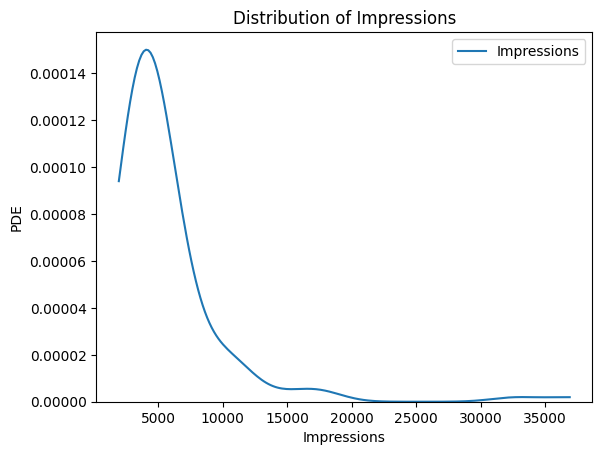

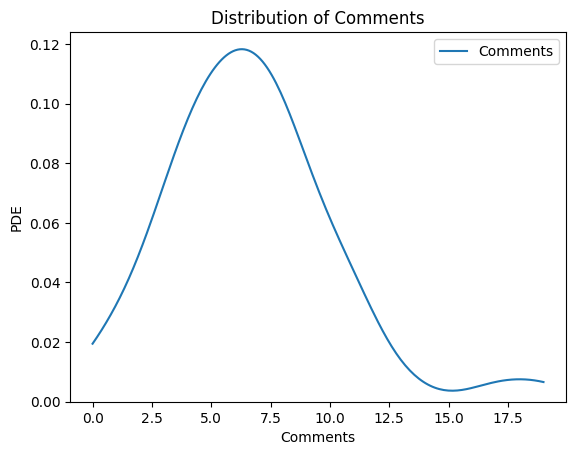

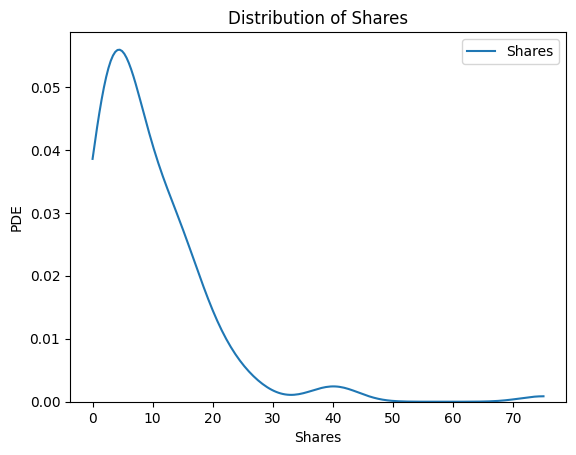

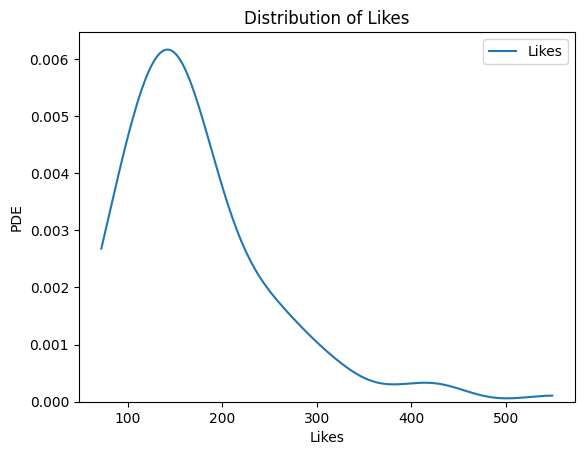

In [5]:
#Distribution of numerical variables 

for column in numerical_data:
    sb.kdeplot(data[column], label = column, cut = 0)
    plt.xlabel(column)
    plt.ylabel('PDE') #PDE (Probability density estimate): probability per unit value of whatever variable is on X-axis. Values are used relatively to compare points on the graph
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()

In [6]:
#Mean & STD of numerical variables 
for column in numerical_data:
    mean = data[column].mean()
    std = data[column].std()
    print(f"Mean of {column}: {mean}, Standard Deviation of {column}: {std}")

Mean of Impressions: 5703.991596638655, Standard Deviation of Impressions: 4843.780104765143
Mean of Comments: 6.663865546218488, Standard Deviation of Comments: 3.544576451292469
Mean of Shares: 9.361344537815127, Standard Deviation of Shares: 10.089204746370548
Mean of Likes: 173.78151260504202, Standard Deviation of Likes: 82.37894659292769


In [9]:
#Generates a sample from normal distribution with given mean and sd, and returns mean of sample 
def simulate_sample_mean(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.mean()

In [10]:
#If call simulate_sample_mean once, we get a single value from the sampling distribution of the mean 
for column in numerical_data:
    mean = data[column].mean()
    std = data[column].std()
    sample_mean = simulate_sample_mean(119, mean, std)
    print(f"Mean of {column}: {sample_mean}")

Mean of Impressions: 5710.824221219182
Mean of Comments: 6.5551812624755845
Mean of Shares: 10.22065329744604
Mean of Likes: 166.3666862000313


In [11]:
def summarize(t, digits=2):
    table = pd.DataFrame(columns=['Estimate', 'SE', 'CI90'])
    est = np.mean(t).round(digits)
    SE = np.std(t).round(digits)
    CI90 = np.percentile(t, [5, 95]).round(digits)
    table.loc[''] = est, SE, CI90
    return table

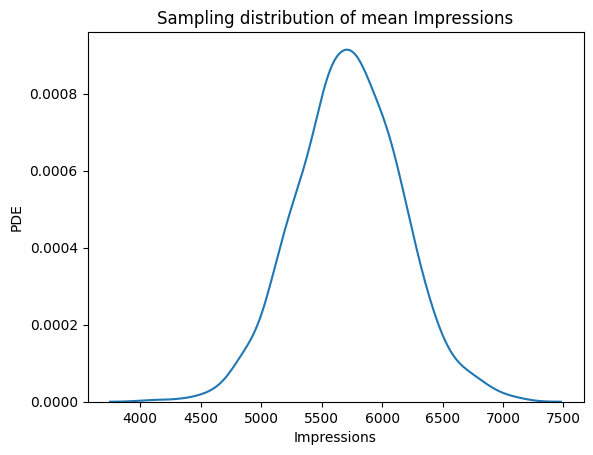

  Estimate     SE              CI90
    5727.1  435.2  [5030.7, 6434.9]


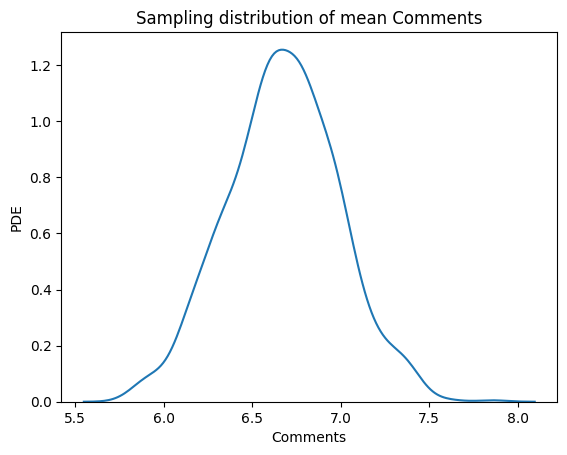

  Estimate   SE        CI90
       6.7  0.3  [6.2, 7.2]


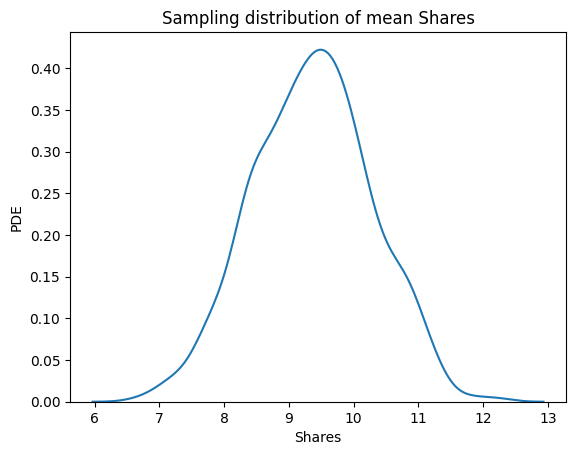

  Estimate   SE         CI90
       9.4  0.9  [7.8, 10.9]


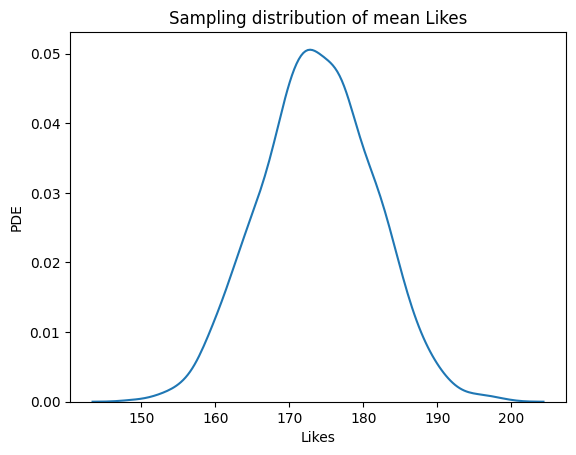

  Estimate   SE            CI90
     173.7  7.6  [161.2, 185.9]


In [12]:
#Getting a random sample from sampling distribution 
sample_distributions = {}

for column in numerical_data:
    mean = data[column].mean()
    std = data[column].std()
    randomsample = [simulate_sample_mean(119, mean, std)
                    for i in range(1000)]
    #Plotting sample distributions of mean 
    sb.kdeplot(randomsample)
    plt.xlabel(column)
    plt.ylabel('PDE') #PDE (Probability density estimate): probability per unit value of whatever variable is on X-axis. Values are used relatively to compare points on the graph
    plt.title(f'Sampling distribution of mean {column}')
    plt.show()
    #Summarise sampling distribution 
    original_summary = summarize(randomsample, digits=1)
    sample_distributions[column] = original_summary
    print(original_summary)

In [13]:
# Number of bootstrap samples to generate 
n_samples = 20

# Function to bootstrap data 
def bootstrap_data(df, n_samples):
    bootstrap_samples = []
    # Loop to generate bootstrap samples 
    for i in range(n_samples):
        # Create an empty DataFrame for each bootstrap sample 
        bootstrap_sample = pd.DataFrame()
        # Loop through each column in the original DataFrame 
        for column in df.columns:
            # Sample with replacement from each column and reset index 
            sample = df[column].sample(n=len(df), replace=True, random_state=1000).reset_index(drop=True)
            # Add the sampled column to the bootstrap sample DataFrame 
            bootstrap_sample[column] = sample
        # Append the bootstrap sample to the list of bootstrap samples 
        bootstrap_samples.append(bootstrap_sample)
    # Return the list of bootstrap samples 
    return bootstrap_samples

# Generate bootstrap samples using the bootstrap_data function 
bootstrap_samples = bootstrap_data(numerical_data, n_samples)

# Concatenate the original data with each bootstrap sample 
for bootstrap_sample in bootstrap_samples:
    # Concatenate the original data with the current bootstrap sample 
    numerical_data = pd.concat([numerical_data, bootstrap_sample], ignore_index=True)

numerical_data

,Impressions,Comments,Shares,Likes
0,3920,9,5,162
1,5394,7,14,224
2,4021,11,1,131
3,4528,10,7,213
4,2518,5,4,123
...,...,...,...,...
2494,4115,6,3,191
2495,2621,5,1,76
2496,5055,7,11,159
2497,11068,7,8,250


In [14]:
def bootstrap_mean(df, varname):
    bootstrapped = df.sample(n=len(df), replace=True)
    return bootstrapped[varname].mean()

In [15]:
for column in numerical_data:
    bootstrapped_sample = [bootstrap_mean(data, column)
      for i in range(1001)]
    #Summarise sampling distribution 
    bootstrapped_summary = summarize(bootstrapped_sample)
    table = pd.concat([sample_distributions[column], bootstrapped_summary])
    table.index = ['normal model', 'bootstrapping']
    print(table)

               Estimate      SE                CI90
normal model     5727.1  435.20    [5030.7, 6434.9]
bootstrapping    5694.9  443.98  [5018.55, 6450.38]
               Estimate    SE         CI90
normal model       6.70  0.30   [6.2, 7.2]
bootstrapping      6.67  0.32  [6.13, 7.2]
               Estimate    SE           CI90
normal model       9.40  0.90    [7.8, 10.9]
bootstrapping      9.44  0.94  [7.93, 10.98]
               Estimate    SE             CI90
normal model     173.70  7.60   [161.2, 185.9]
bootstrapping    173.91  7.54  [161.81, 187.3]


#### 2.3.2 Bootstrapping Text Data

In [16]:
#Function to sample data with replacement
def sample_data(data, num_samples, random_state=69):
    return data.sample(n=num_samples, replace=True, random_state=random_state)

# Function to replace words with synonyms using WordNet
def replace_words_with_synonyms(text):
    words = word_tokenize(text)
    augmented_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Use the first synonym to preserve context
            synonym = synonyms[0].lemmas()[0].name()
            augmented_words.append(synonym)
        else:
            augmented_words.append(word)
    # Join the words into a sentence
    return ' '.join(augmented_words)

# Function to shuffle words in text
def shuffle_words(text):
    words = word_tokenize(text)
    random.shuffle(words)
    return ' '.join(words)

# Tokenize, remove stopwords, and preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

# Stemming function using PorterStemmer
def apply_stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

# Lemmatization function using WordNetLemmatizer
def apply_lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Function to preprocess data: tokenization, stemming, and lemmatization
def preprocess_data(input_df):
    df = input_df.copy()  # Work with a copy of the DataFrame

    # Combine 'Caption' and 'Hashtags' columns
    df['full_caption'] = df['Caption'] + ' ' + df['Hashtags']
    # Remove non-breaking spaces and lowercase the text
    df['full_caption'] = df['full_caption'].str.replace(u'\xa0', u' ')
    df['full_caption'] = df['full_caption'].str.lower()

    # Apply text preprocessing, tokenization, stemming, and lemmatization
    df['Tokenized_Text'] = df['full_caption'].apply(preprocess_text)
    df['Stemmed_Text'] = df['Tokenized_Text'].apply(apply_stemming)
    df['Lemmatized_Text'] = df['Stemmed_Text'].apply(apply_lemmatization)

    # Apply the same operations to the 'Hashtags' column
    df['Tokenized_Hashtags'] = df['Hashtags'].apply(preprocess_text)
    df['Stemmed_Hashtags'] = df['Tokenized_Hashtags'].apply(apply_stemming)
    df['Lemmatized_Hashtags'] = df['Stemmed_Hashtags'].apply(apply_lemmatization)

    # Convert lists of tokens back to space-separated strings
    df['Caption'] = df['Lemmatized_Text'].apply(lambda x: ' '.join(x))
    df['Hashtags'] = df['Lemmatized_Hashtags'].apply(lambda x: ' '.join(x))

    # Drop the unnecessary columns
    df = df.drop(columns=['full_caption', 'Tokenized_Text', 'Stemmed_Text', 'Lemmatized_Text',
                          'Tokenized_Hashtags', 'Stemmed_Hashtags', 'Lemmatized_Hashtags'])

    # Return the modified DataFrame
    return df

# Usage example:
# Assuming you have a DataFrame called `input_df` with columns 'Caption' and 'Hashtags':
# cleaned_df = preprocess_data(input_df)

In [17]:
# Calculate the number of rows needed
target = 2499
required_rows = target - len(temp)

# Sample data and apply text augmentation functions
new_rows = sample_data(temp, required_rows)
new_rows['Caption'] = new_rows['Caption'].apply(replace_words_with_synonyms)
new_rows['Hashtags'] = new_rows['Hashtags'].apply(shuffle_words)

# Concatenate original data with the new rows
expandedData = pd.concat([temp, new_rows], ignore_index=True)
expandedData = preprocess_data(expandedData)

In [18]:
#data = data.drop(columns=['Caption','Hashtags'])
expandedData = expandedData.drop(columns=['Impressions','Comments','Shares','Likes'])
data = pd.concat([numerical_data,expandedData],axis=1)

The variable 'data' now contains the original data concatenated with all bootstrap samples 

### 2.4 Exploring Numerical & Text variables of Dataset 

#### 2.4.1 Numerical Visualisation

In [19]:
# Reindex the DataFrame 
data = data.reindex()

In [20]:
# Extract list of columns
data_cols = list(data.columns)
print('Dataset columns: {}'.format(data_cols))

Dataset columns: ['Impressions', 'Comments', 'Shares', 'Likes', 'Caption', 'Hashtags']


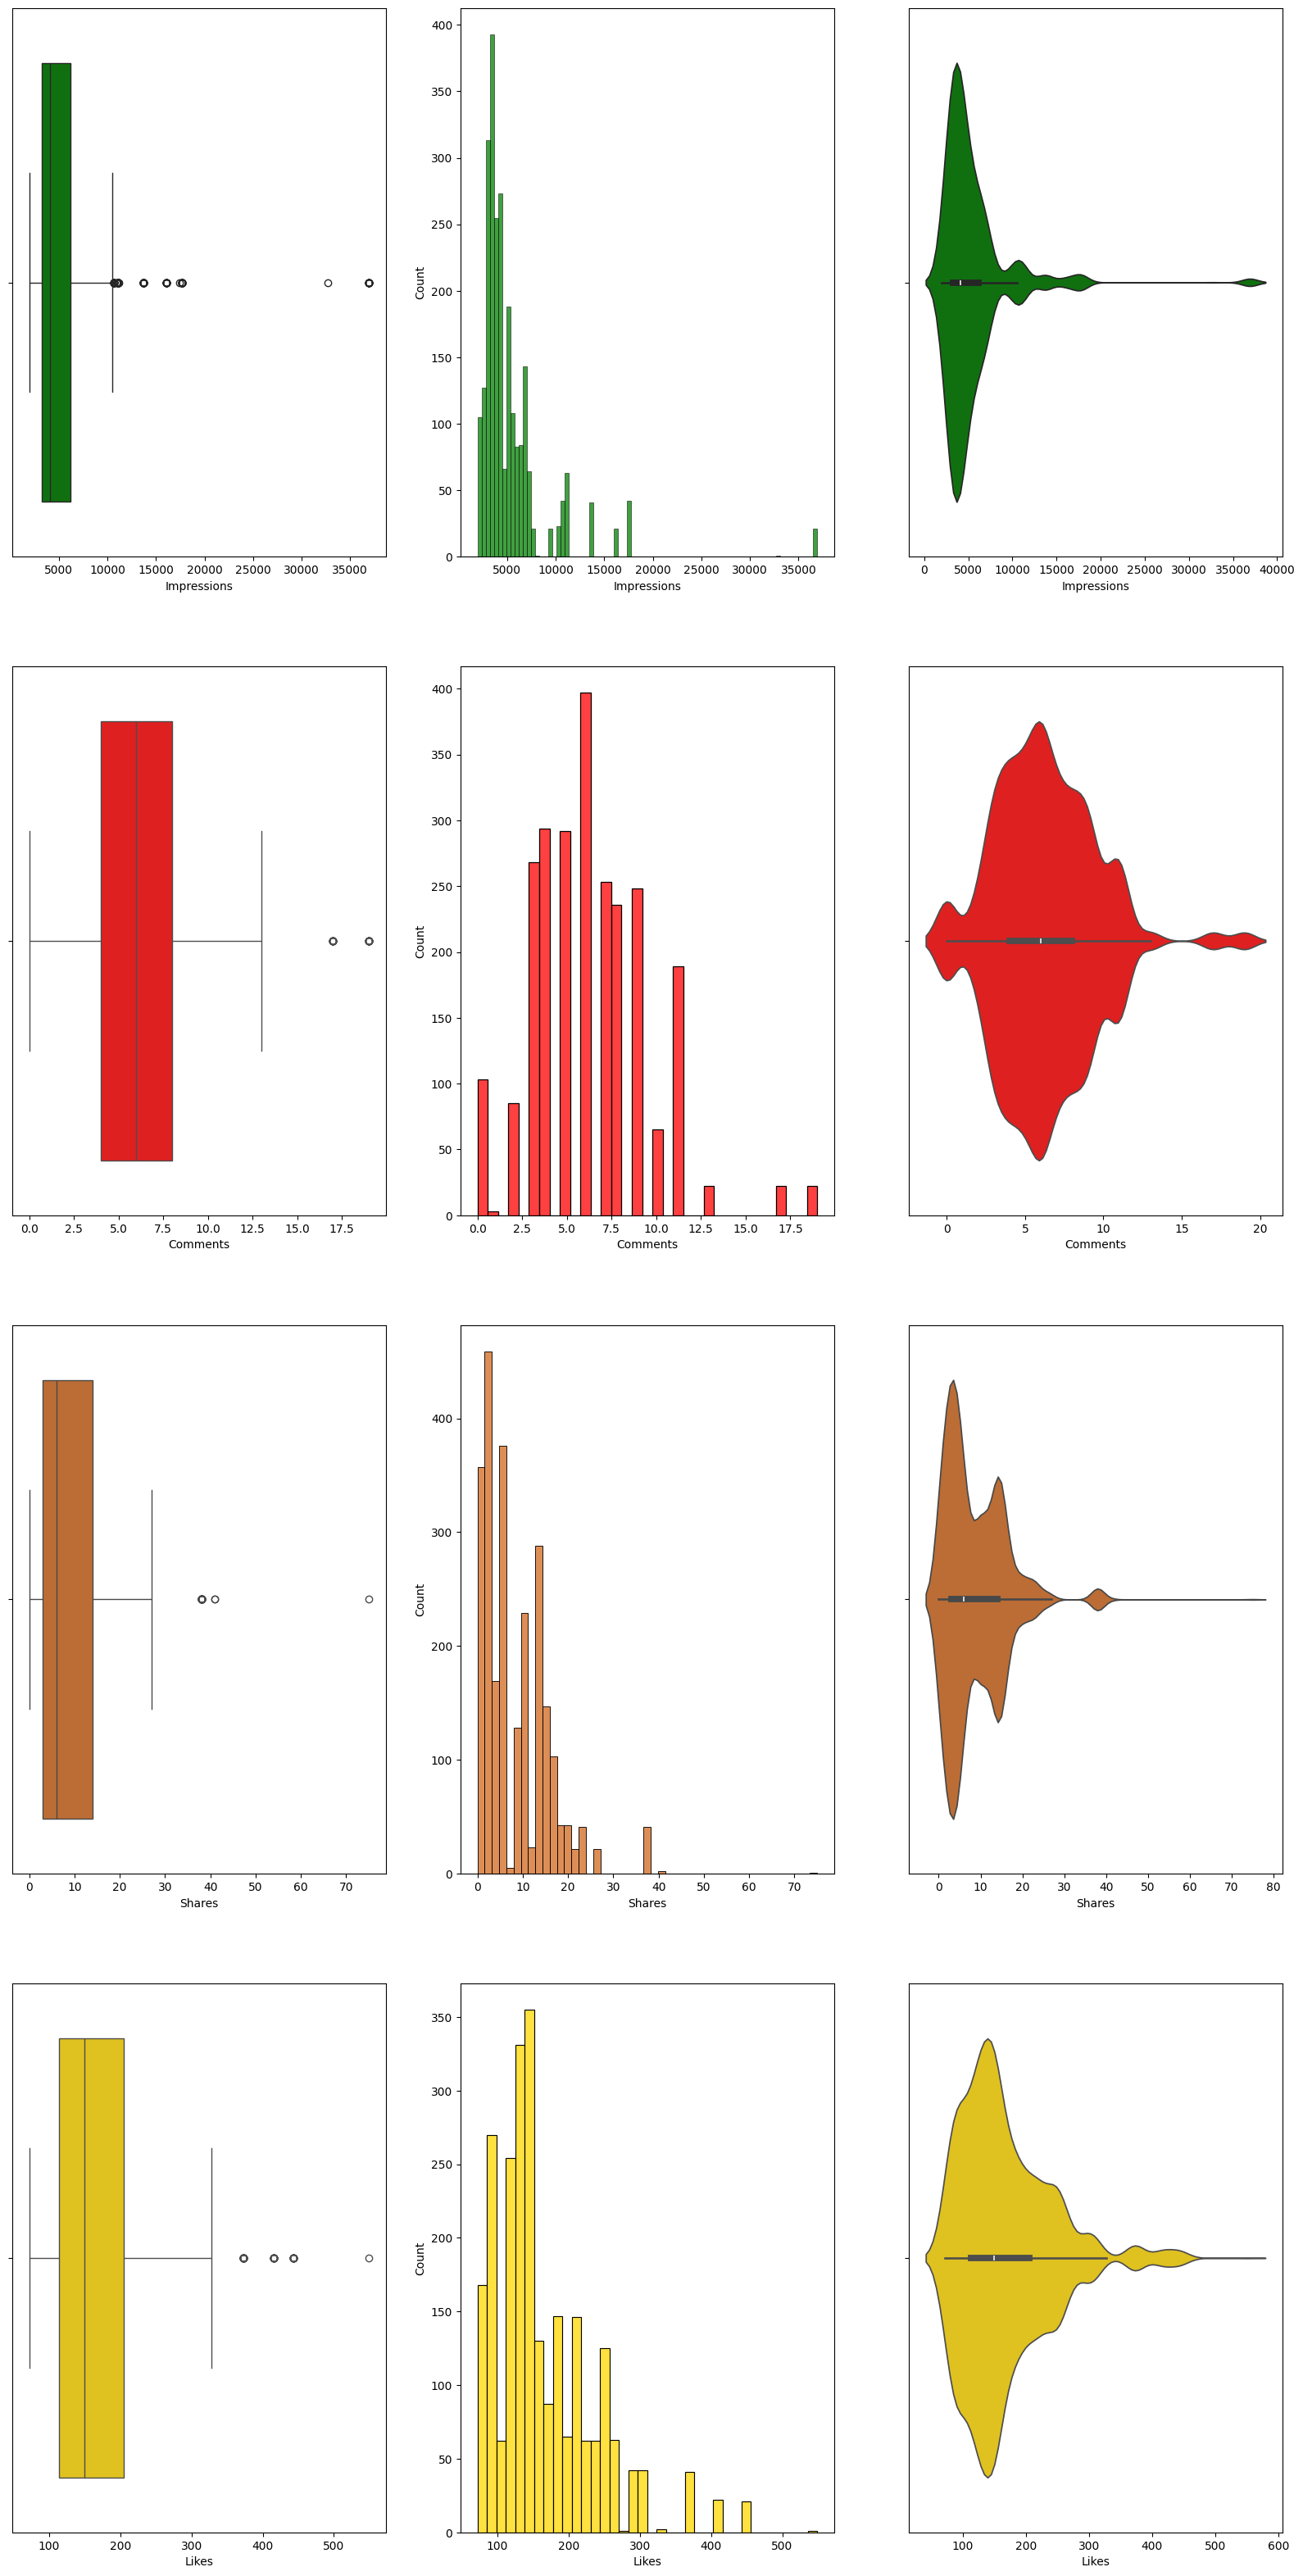

In [21]:
# Draw the distribution of numerical variables 
f, axes = plt.subplots(4,3, figsize=(20,40))
colours = ['green', 'red', 'chocolate', 'gold']

count = 0
for i in range(4):
    sb.boxplot(x = data[data_cols[i]], orient = 'h', color = colours[count], ax = axes[count,0])
    sb.histplot(x = data[data_cols[i]], color = colours[count], ax = axes[count,1])
    sb.violinplot(x = data[data_cols[i]], color = colours[count], ax = axes[count,2])
    count+=1

#### 2.4.2 Text Visualisation

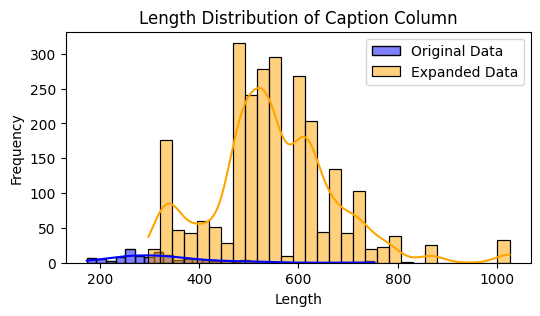

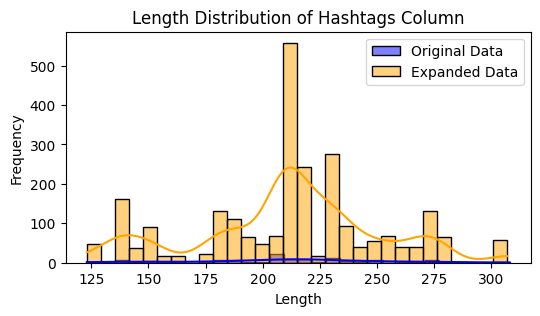

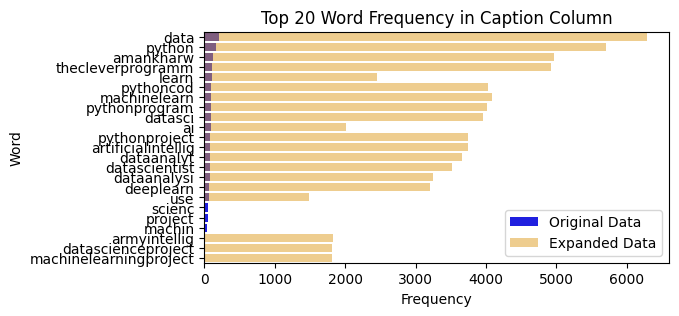

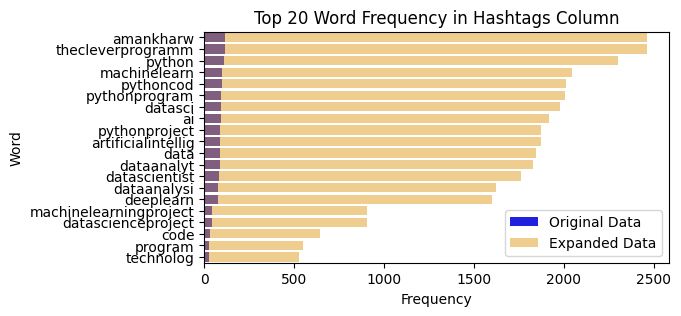

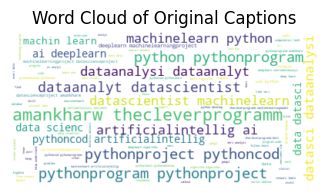

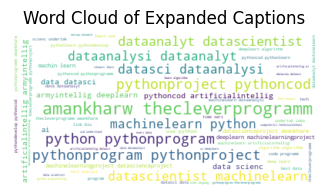

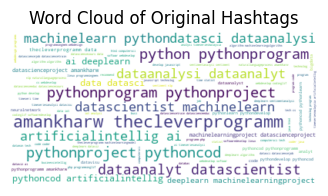

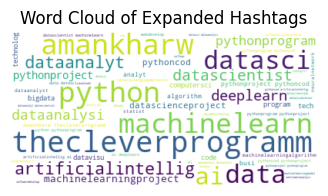

In [22]:


# Function to plot length distributions
def plot_length_distributions(original_data, expanded_data, column):
    plt.figure(figsize=(6, 3))
    # Histogram for original data
    sb.histplot(original_data[column].str.len(), bins=30, label='Original Data', color='blue', alpha=0.5, kde=True)
    # Histogram for expanded data
    sb.histplot(expanded_data[column].str.len(), bins=30, label='Expanded Data', color='orange', alpha=0.5, kde=True)
    plt.title(f'Length Distribution of {column} Column')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Function to plot word frequency distributions
def plot_word_frequency(original_data, expanded_data, column):
    original_freq = original_data[column].str.split().explode().value_counts()
    expanded_freq = expanded_data[column].str.split().explode().value_counts()
    
    # Limit to the top 20 words for better visualization
    original_freq_top20 = original_freq[:20]
    expanded_freq_top20 = expanded_freq[:20]

    plt.figure(figsize=(6, 3))
    sb.barplot(x=original_freq_top20.values, y=original_freq_top20.index, color='blue', label='Original Data')
    sb.barplot(x=expanded_freq_top20.values, y=expanded_freq_top20.index, color='orange', label='Expanded Data', alpha=0.5)
    plt.title(f'Top 20 Word Frequency in {column} Column')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.legend()
    plt.show()

# Function to generate word cloud
def generate_word_cloud(data, column, title):
    text = ' '.join(data[column])
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    
    plt.figure(figsize=(5, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plotting the length distributions for captions and hashtags
plot_length_distributions(temp, data, 'Caption')
plot_length_distributions(temp, data, 'Hashtags')

# Plotting the word frequency distributions for captions and hashtags
plot_word_frequency(temp, data, 'Caption')
plot_word_frequency(temp, data, 'Hashtags')

# Generating word clouds for captions and hashtags
generate_word_cloud(temp, 'Caption', 'Word Cloud of Original Captions')
generate_word_cloud(data, 'Caption', 'Word Cloud of Expanded Captions')

generate_word_cloud(temp, 'Hashtags', 'Word Cloud of Original Hashtags')
generate_word_cloud(data, 'Hashtags', 'Word Cloud of Expanded Hashtags')


### 2.5 Cleaning the numerical variables of Dataset 

2.5.1 Once we are done with the basic exploration of numerical variables, it's time to clean and tidy-up the dataset. This is done by identifying and removing outliers from the data.

Impressions    210
Comments        44
Shares          44
Likes           85
dtype: int64

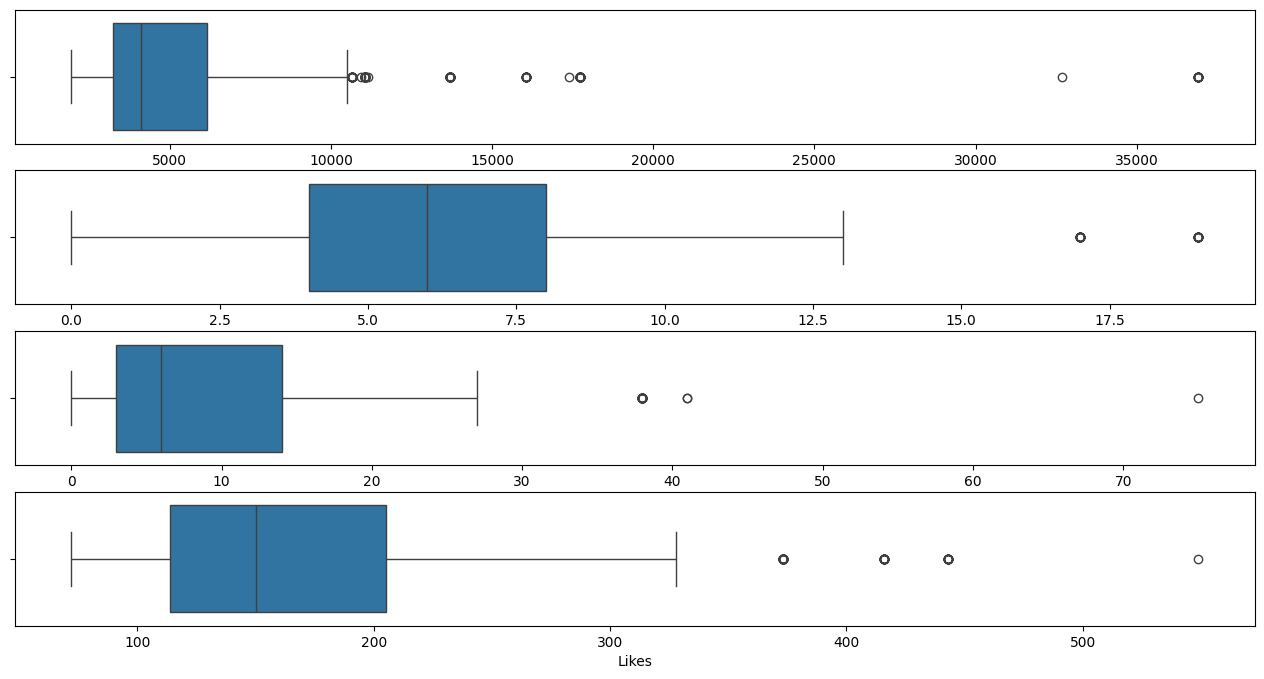

In [23]:
# Extract the two variables
targetData = data[['Impressions', 'Comments','Shares', 'Likes']].copy()
# Make a clean "copy" and not just a slice of the dataset

# Draw the boxplots
f, axes = plt.subplots(4, 1, figsize=(16, 8))

sb.boxplot(data = targetData["Impressions"], orient = "h", ax = axes[0])
sb.boxplot(data = targetData["Comments"], orient = "h", ax = axes[1])
sb.boxplot(data = targetData["Shares"], orient = "h", ax = axes[2])
sb.boxplot(data = targetData["Likes"], orient = "h", ax = axes[3])


# Calculate the quartiles
Q1 = targetData.quantile(0.25)
Q3 = targetData.quantile(0.75)

# Rule to identify outliers
rule = ((targetData < (Q1 - 1.5 * (Q3 - Q1))) | (targetData > (Q3 + 1.5 * (Q3 - Q1))))

# Count the number of outliers
rule.sum()

In [24]:
# Calculate the quartiles
Q1 = targetData.quantile(0.25)
Q3 = targetData.quantile(0.75)

# Rule to identify outliers
rule = ((targetData < (Q1 - 1.5 * (Q3 - Q1))) | (targetData > (Q3 + 1.5 * (Q3 - Q1))))

# Check the dataframe rule
rule

,Impressions,Comments,Shares,Likes
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
2494,False,False,False,False
2495,False,False,False,False
2496,False,False,False,False
2497,True,False,False,False


In [25]:
# Find the rows where ANY column is True
outliers = rule.any(axis = 1)   # axis 0 is row, 1 is column

# Check the outliers -- it's a boolean Series
outliers


0       False
1       False
2       False
3       False
4       False
        ...  
2494    False
2495    False
2496    False
2497     True
2498    False
Length: 2499, dtype: bool

In [26]:
outlierindices = outliers.index[outliers == True]
outlierindices

Index([  16,   26,   40,   49,   54,   67,   83,   90,   95,  105,
       ...
       2397, 2404, 2406, 2408, 2431, 2434, 2444, 2455, 2473, 2497],
      dtype='int64', length=256)

In [27]:
# Remove the outliers based on the row indices obtained above
data.drop(axis = 0,               # 0 drops row 1 drops column
                index = outlierindices, # this takes a list as input
                inplace = True)         # not overwritten by default 

# Check the clean data
data

,Impressions,Comments,Shares,Likes,Caption,Hashtags
0,3920,9,5,162,import data visual everi financ data analystsc...,financ money busi invest invest trade stockmar...
1,5394,7,14,224,best data scienc project idea healthcar want b...,healthcar health covid data datasci dataanalys...
2,4021,11,1,131,learn train machin learn model give input trai...,data datasci dataanalysi dataanalyt datascient...
3,4528,10,7,213,write python program detect whether sentenc qu...,python pythonprogram pythonproject pythoncod p...
4,2518,5,4,123,plot annot visual data consid good practic mak...,datavisu datasci data dataanalyt machinelearn ...
...,...,...,...,...,...,...
2493,4467,3,16,149,time seri analysi mean analyz discoveri form t...,timeseri bigdata thecleverprogramm statist ana...
2494,4115,6,3,191,time seri analysi mean analyz discoveri form t...,datasci thecleverprogramm timeseri analysi ana...
2495,2621,5,1,76,best data scienc undertak idea resum tri data ...,machinelearn dataanalyt dataanalysi deeplearn ...
2496,5055,7,11,159,varianc covari correl statist measur discoveri...,dataviz data datasci dataanalyst machinelearn ...


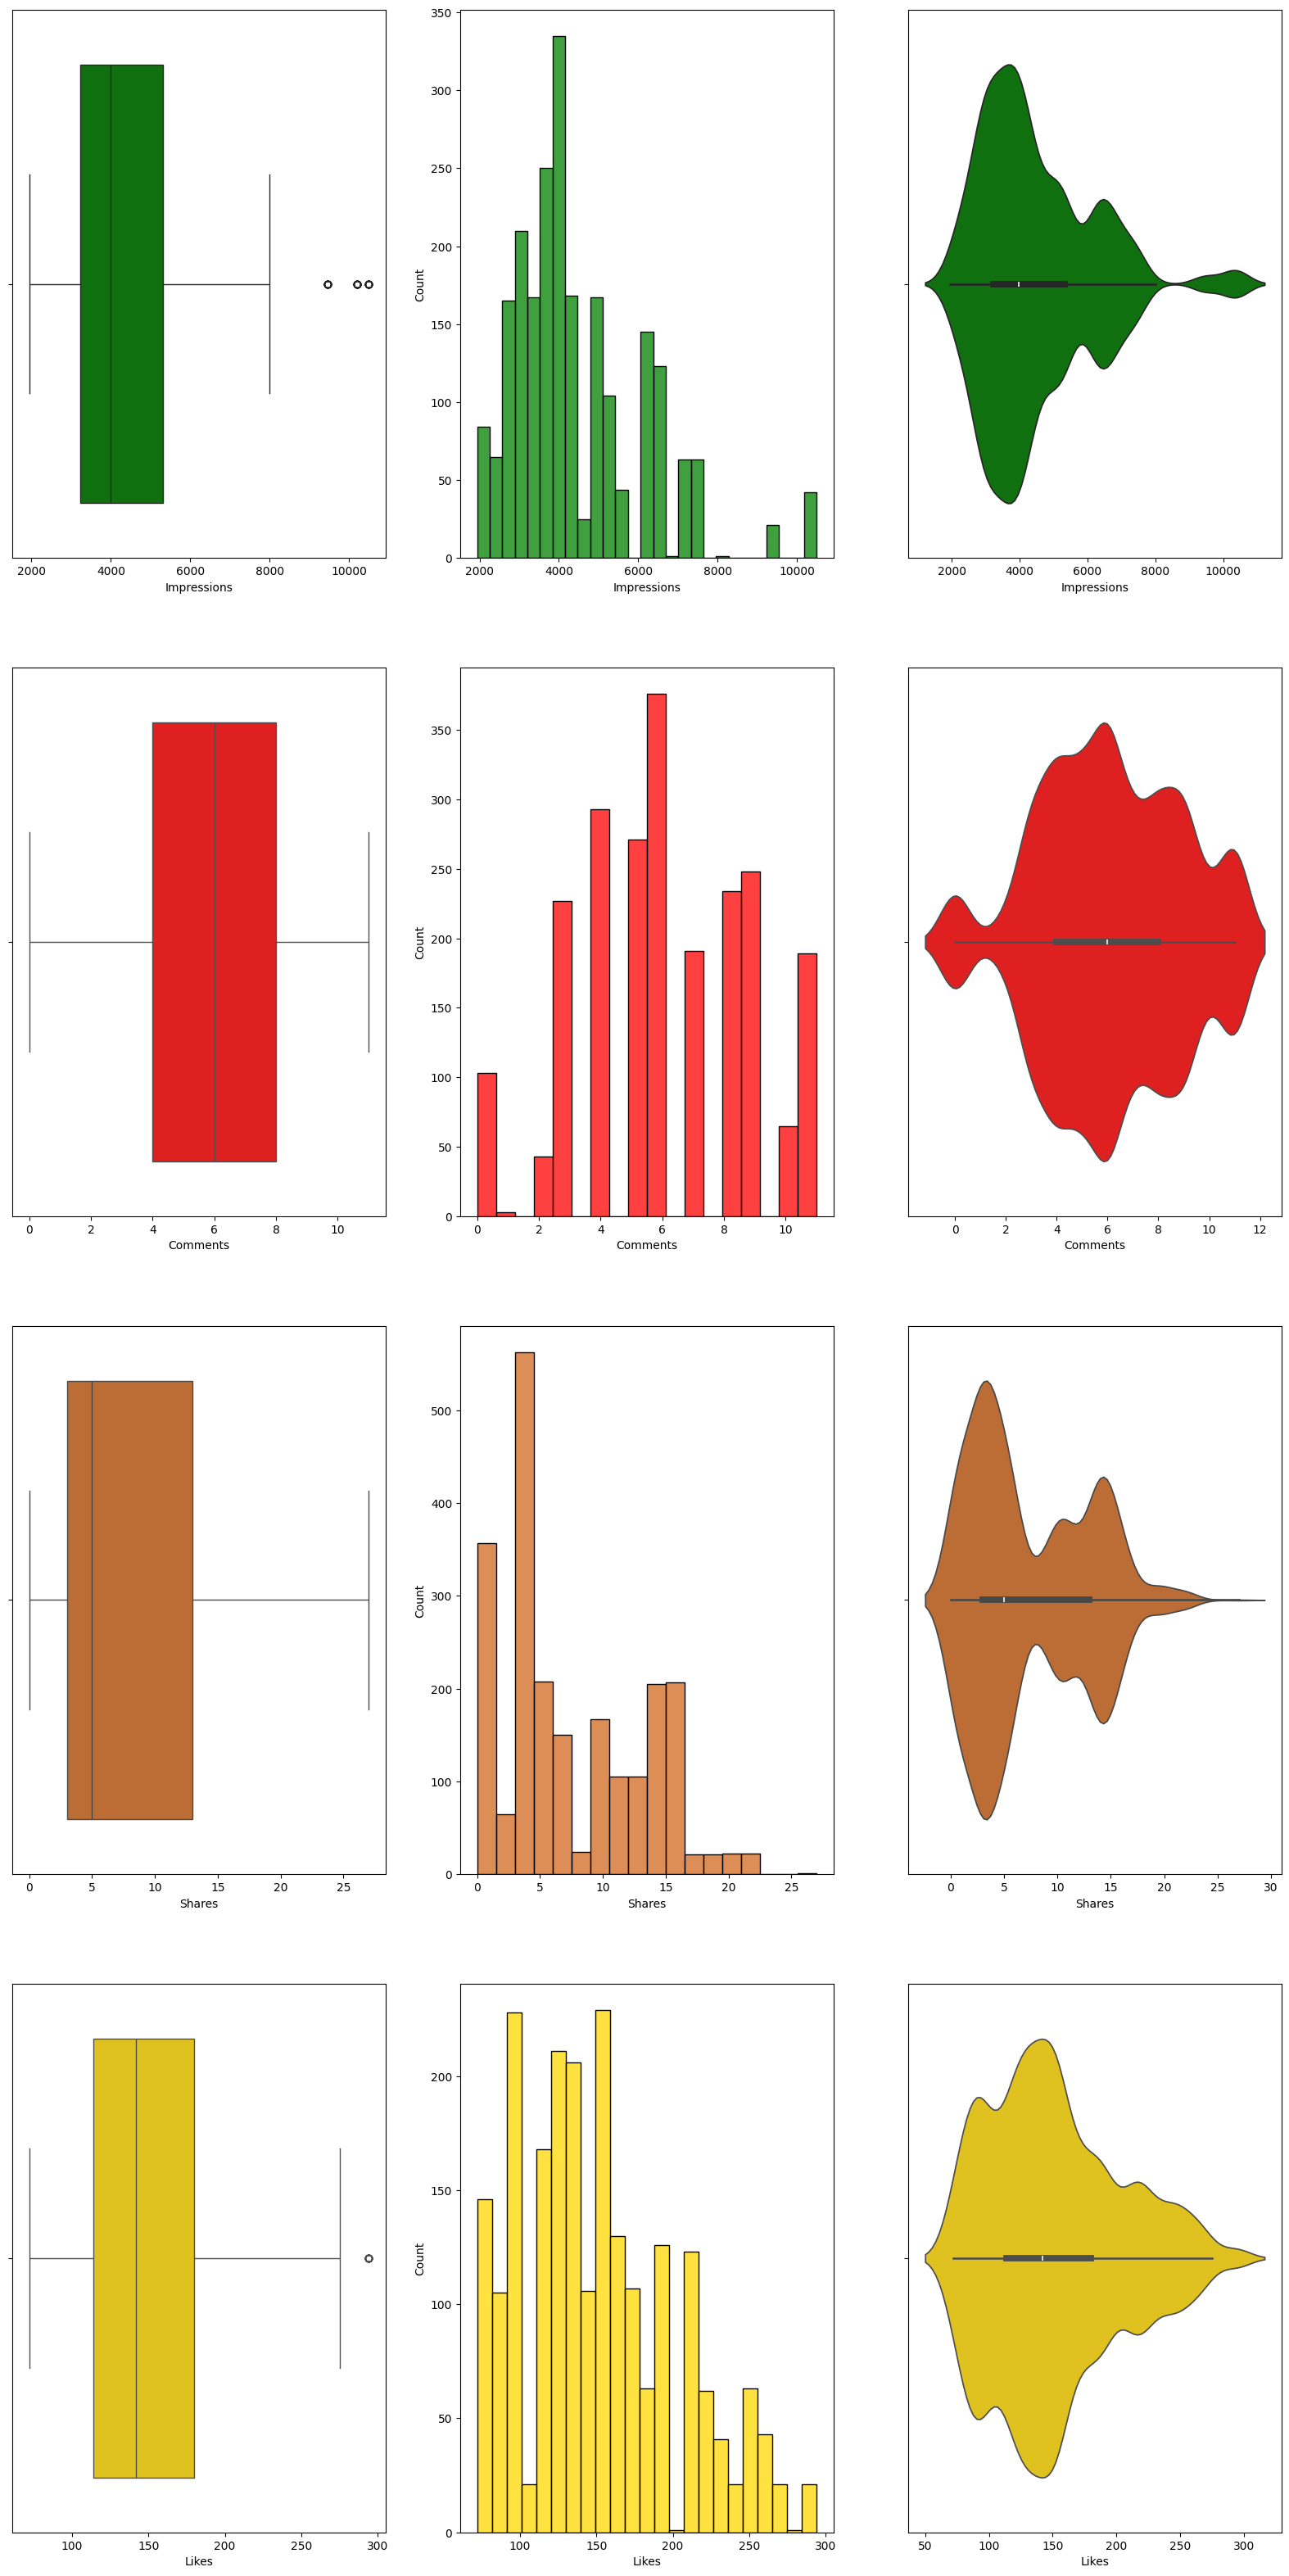

In [28]:
# Draw the distribution of cleaned numerical variables 
f, axes = plt.subplots(4,3, figsize=(20,40))
colours = ['green', 'red', 'chocolate', 'gold']

count = 0
for i in range(4):
    sb.boxplot(x = data[data_cols[i]], orient = 'h', color = colours[count], ax = axes[count,0])
    sb.histplot(x = data[data_cols[i]], color = colours[count], ax = axes[count,1])
    sb.violinplot(x = data[data_cols[i]], color = colours[count], ax = axes[count,2])
    count+=1

#### 2.5.2 Converting Caption & Hashtag to List of Tokens and Exporting

In [29]:
exportBS = data
exportBS['Caption'] = exportBS['Caption'].apply(lambda x: word_tokenize(x))
exportBS['Hashtags'] = exportBS['Hashtags'].apply(lambda x: word_tokenize(x))
exportBS

,Impressions,Comments,Shares,Likes,Caption,Hashtags
0,3920,9,5,162,"[import, data, visual, everi, financ, data, an...","[financ, money, busi, invest, invest, trade, s..."
1,5394,7,14,224,"[best, data, scienc, project, idea, healthcar,...","[healthcar, health, covid, data, datasci, data..."
2,4021,11,1,131,"[learn, train, machin, learn, model, give, inp...","[data, datasci, dataanalysi, dataanalyt, datas..."
3,4528,10,7,213,"[write, python, program, detect, whether, sent...","[python, pythonprogram, pythonproject, pythonc..."
4,2518,5,4,123,"[plot, annot, visual, data, consid, good, prac...","[datavisu, datasci, data, dataanalyt, machinel..."
...,...,...,...,...,...,...
2493,4467,3,16,149,"[time, seri, analysi, mean, analyz, discoveri,...","[timeseri, bigdata, thecleverprogramm, statist..."
2494,4115,6,3,191,"[time, seri, analysi, mean, analyz, discoveri,...","[datasci, thecleverprogramm, timeseri, analysi..."
2495,2621,5,1,76,"[best, data, scienc, undertak, idea, resum, tr...","[machinelearn, dataanalyt, dataanalysi, deeple..."
2496,5055,7,11,159,"[varianc, covari, correl, statist, measur, dis...","[dataviz, data, datasci, dataanalyst, machinel..."


In [30]:
export = temp
export['Caption'] = export['Caption'].apply(lambda x: word_tokenize(x))
export['Hashtags'] = export['Hashtags'].apply(lambda x: word_tokenize(x))
export

,Impressions,Comments,Shares,Likes,Caption,Hashtags
0,3920,9,5,162,"[import, data, visual, everi, financi, data, a...","[financ, money, busi, invest, invest, trade, s..."
1,5394,7,14,224,"[best, data, scienc, project, idea, healthcar,...","[healthcar, health, covid, data, datasci, data..."
2,4021,11,1,131,"[learn, train, machin, learn, model, give, inp...","[data, datasci, dataanalysi, dataanalyt, datas..."
3,4528,10,7,213,"[here, write, python, program, detect, whether...","[python, pythonprogram, pythonproject, pythonc..."
4,2518,5,4,123,"[plot, annot, visual, data, consid, good, prac...","[datavisu, datasci, data, dataanalyt, machinel..."
...,...,...,...,...,...,...
114,13700,2,38,373,"[best, data, scienc, certif, choos, datasci, d...","[datasci, datasciencejob, datasciencetrain, da..."
115,5731,4,1,148,"[cluster, machin, learn, techniqu, use, classi...","[machinelearn, machinelearningalgorithm, datas..."
116,4139,0,1,92,"[cluster, music, genr, task, group, music, bas...","[machinelearn, machinelearningalgorithm, datas..."
117,32695,2,75,549,"[best, data, scienc, certif, choos, datasci, d...","[datasci, datasciencejob, datasciencetrain, da..."


In [31]:
exportBS.to_csv("Datasets/BootstrappedAndNoOutlier.csv")
export.to_csv("Datasets/cleaned-IG-data.csv")